### Framing classifier using BERT 

This model will shift towards a multi-class classification. The goal is to generate a model that can be used in social network analysis and social media content analysis while being fairly lightweight.
Downstream, it will be evaluated on a gold standard media frame corpus dataset. https://aclanthology.org/P15-2072.pdf

As the v1 notebook, this will contain all the experimental code and EDA for the initial stage of model development, carrying on from the lessons found in the topic classifier v2.

Frame prediction is much more complicated task than single topic prediction. We will see how far we can get with a base roBerta model with long-doc policy. Then we will likely expand to a larger model or combine BERTs. Data filtering to specific issue areas may also prove useful. 

Generic frames include non-issue specific frames that are generalizable across issues areas. The media frame corpus dataset lays out a set of 15


In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from dotenv import load_dotenv
import os
import transformers
load_dotenv()  # looks for .env in current directory or parent
print(torch.__version__)
print(torch.cuda.is_available())


2.6.0+cu124
True


### Sample the data, ensure same categories as the media frames corpus

In [2]:
# Connect to server 
import psycopg2
conn = psycopg2.connect(
    dbname=os.getenv("DB_NAME"),
    user=os.getenv("DB_USER"),
    password=os.getenv("DB_PASSWORD"),
    host=os.getenv("DB_HOST"),
    port=os.getenv("DB_PORT")
)
cur = conn.cursor()

# key: set the seed
cur.execute("SELECT setseed(0.42)")

# Do our join in database - NOTE this is with a POLITICS FILTER
cur.execute(f"""
           SELECT a.text_generic_frame, a.gpt_topic, a.political_leaning, a.title,  
           b.maintext
           FROM mm_framing_full a
           JOIN newsarticles b ON a.url = b.url
           ORDER BY RANDOM()
            LIMIT 200000
            """)

result= cur.fetchall()

print(cur.description)

cur.close()
conn.close()

df = pd.DataFrame(result, columns=["text_generic_frame", "gpt_topic", "political_leaning", "title", "article_text"])

del result

df.head()

(Column(name='text_generic_frame', type_code=1009), Column(name='gpt_topic', type_code=25), Column(name='political_leaning', type_code=25), Column(name='title', type_code=25), Column(name='maintext', type_code=25))


,text_generic_frame,gpt_topic,political_leaning,title,article_text
0,"[Health and safety, Policy prescription and ev...",Sports,left_lean,The extreme heat is impacting Friday night foo...,Mansfield ISD is making changes within the foo...
1,"[External regulation and reputation, Policy pr...",Politics,left_lean,"House Republicans are in chaos again, fighting...","WASHINGTON — A band of hard-right agitators, b..."
2,"[Crime and punishment, Health and safety]",Disaster & Accidents,left_lean,"Frisco ISD student struck, killed while riding...",A 15-year-old Frisco ISD student was struck an...
3,"[Cultural identity, External regulation and re...",Sports,left_lean,CBS announces exclusive weeklong residency in ...,CBS has announced an exclusive residency in La...
4,"[Cultural identity, Policy prescription and ev...",Entertainment,left,Joe Jonas Wears Wedding Ring Amid Sophie Turne...,LOADINGERROR LOADING\nJoe Jonas left his fans ...


### Sample the data, ensure same categories as the media frames corpus

<Axes: ylabel='Frequency'>

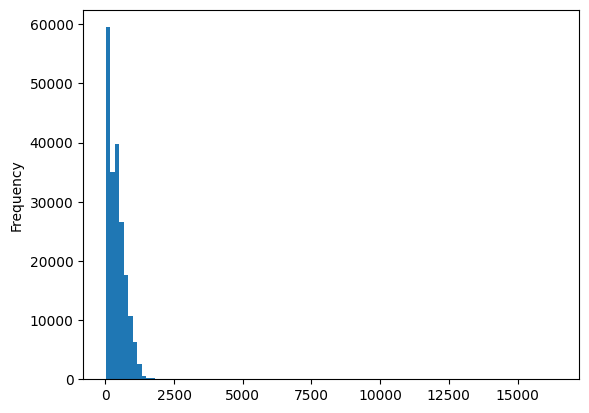

In [3]:
df['num_words'] = df['article_text'].str.split().str.len()

df['num_words'].plot.hist(bins=100)

### Initial data filtering
* Keep the same minimum length requirement  
* Noting the above histogram, we might exclude articles that are over 1000 words. This also gives BERT a fighting chance initially.


In [4]:
print(f"Original rows: {len(df)}")

df_filtered = df[(df['num_words'] > 100) & (df['num_words'] <= 1500)]
df = df_filtered.dropna()
df = df.reset_index()

print(f"Filtered rows: {len(df_filtered)}")

del df_filtered


Original rows: 200000
Filtered rows: 149437


### Data preprocessing


In [ ]:
# all_frames = set(df['text_generic_frame'].sum())

# counts = df['text_generic_frame'].explode().value_counts()

# pd.set_option('display.max_rows', None)
# print(counts)

# phew - at least the times when it's not part of the 15 categories seem to be extreme outliers

text_generic_frame
Quality of life                                  36726
Policy prescription and evaluation               33434
Economic                                         30851
Crime and punishment                             29117
Political                                        28981
Legality, constitutionality and jurisprudence    28369
Public opinion                                   27756
Fairness and equality                            21469
Health and safety                                21195
Cultural identity                                20661
Security and defense                             19008
External regulation and reputation               15831
Capacity and resources                           11343
Other                                            10798
Morality                                          6710
Name: count, dtype: int64


In [7]:
# Keep rows where the list is NOT exactly ['Other']
# df = df[df['cleaned_frames'].apply(lambda x: x != ['Other'])]
# print(f"Rows remaining: {len(df)}")

In [5]:
# Append title
df['article_text'] = df['title'] + "\n" + df['article_text']

# Then append TOPIC 
df['article_text'] = "TOPIC: " + df['gpt_topic'] + "\n" + df['article_text']


In [16]:
index = 34
print(f"Generic Topics: {df.iloc[index]['text_generic_frame']}")
print(df.iloc[index]['article_text'])

Generic Topics: ['Economic', 'Capacity and resources', 'Legality, constitutionality and jurisprudence']
TOPIC: Legal
Trump has been unable to get bond for $464 million judgment, his lawyers say
Former President Donald Trump has not been able to get a bond to secure the $464 million civil fraud judgment against him and his co-defendants, his lawyers said in a court filing Monday.
Trump and his company need to post a bond for the full amount by next week in order to stop New York Attorney General Letitia James from being able to collect while he appeals. They've asked an appeals court to step in in the meantime and said Monday that they have not had any success getting a bond.
"Defendants’ ongoing diligent efforts have proven that a bond in the judgment’s full amount is 'a practical impossibility,'" the filing said. "These diligent efforts have included approaching about 30 surety companies through 4 separate brokers."
Their efforts, including “countless hours negotiating with one of the

### Tokenization + long doc policy
* At this point, I'm happy with the dataset quality, so we'll move forward with the defined pipeline

In [17]:
from transformers import AutoTokenizer

# choosing a base tokenizer model, this won't 
model_name = "FacebookAI/roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# generally want to keep the tokenizations in a separate variable rather than adding them back to the dataframe (for efficiency, taking advantage of the batching features of the huggingface tokenizer)

encodings = tokenizer(df['article_text'].tolist(),                      # we opt to dynamically do padding later with head/tail strategy
                      # hence we also don't need truncation here
                      )

Token indices sequence length is longer than the specified maximum sequence length for this model (1565 > 512). Running this sequence through the model will result in indexing errors


In [18]:
# Code to set the unique head and tail of the articles
head_len = 320
tail_len = 190
content_len = head_len + tail_len          
max_len = content_len + 2  # [CLS] + [SEP]      

cls_id = tokenizer.cls_token_id
sep_id = tokenizer.sep_token_id
pad_id = tokenizer.pad_token_id

for i, ids in enumerate(encodings["input_ids"]):
    # ClS and Sep Id's are present in tokenized values, so do this
    if len(ids) >= 2 and ids[0] == cls_id and ids[-1] == sep_id:
        ids = ids[1:-1]

    # Head+tail on the content tokens
    if len(ids) > content_len:
        head = ids[:head_len]
        tail = ids[-tail_len:]
        ids = head + tail

    # Add specials back
    ids = [cls_id] + ids + [sep_id]

    # Build attention mask (1 for real tokens)
    mask = [1] * len(ids)

    # Pad (or truncate)
    if len(ids) < max_len:
        pad_n = max_len - len(ids)
        ids = ids + [pad_id] * pad_n
        mask = mask + [0] * pad_n
    else:
        ids = ids[:max_len]
        mask = mask[:max_len]

    # Write back
    encodings["input_ids"][i] = ids
    encodings["attention_mask"][i] = mask

# quick sanity check
for ids, mask in zip(encodings["input_ids"][:10], encodings["attention_mask"][:10]):
    assert len(ids) == 512 and len(mask) == 512
    print(ids[:3], sum(mask))

[0, 28332, 2371] 512
[0, 28332, 2371] 512
[0, 28332, 2371] 506
[0, 28332, 2371] 512
[0, 28332, 2371] 512
[0, 28332, 2371] 512
[0, 28332, 2371] 512
[0, 28332, 2371] 256
[0, 28332, 2371] 512
[0, 28332, 2371] 274


### PyTorch Dataset Creation

Using `torch.utils.data.Dataset` and `torch.utils.data.DataLoader`

[Pytorch data tutorial](https://docs.pytorch.org/tutorials/beginner/basics/data_tutorial.html)

* Key change from topic classifier workflow is to establish multi-class prediction

To do this, need to change:
* label shape, we need it to be a binary vector (list of 0 and 1s) the length of total categories (15), we can use https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MultiLabelBinarizer.html
* standard multi-label loss functions (like `BCEWithLogitsLoss`) need targets to be floats, so we change our label tensor dtype to torch.float
* continue filtering out the non-tensor data stuff in batch loading

In [23]:
from sklearn.preprocessing import MultiLabelBinarizer
# Firstly we binarize the frame labels

official_labels = [
    "Economic", "Capacity and resources", "Morality", "Fairness and equality",
    "Legality, constitutionality and jurisprudence", "Policy prescription and evaluation",
    "Crime and punishment", "Security and defense", "Health and safety",
    "Quality of life", "Cultural identity", "Public opinion", "Political",
    "External regulation and reputation", "Other"
]

#  Initialize and Fit
mlb = MultiLabelBinarizer(classes=official_labels)
mlb.fit(df['text_generic_frame']) # Fit on your data (or just the list of labels)

# Transform data into the binary matrix
# creates a big matrix of 0s and 1s
labels_matrix = mlb.transform(df['text_generic_frame'])

# sanity check
# labels_matrix.shape should be (Num_Rows, 15)
print(labels_matrix.shape)

# we should also save the binarizer object in case we need it later after training a good model
import joblib
joblib.dump(mlb, 'encoders/mlb_15_classes_r4.pkl')

(148593, 15)


['encoders/mlb_15_classes_r4.pkl']

In [24]:
# Modifying the below to record the raw text, but filter this out in batch processing since it's not a tensor

from torch.utils.data import Dataset

class NewsArticleDataset(Dataset):
    def __init__(self, encodings, labels_matrix, df):
        """
        encodings: result from tokenizer(text, truncation=True, padding=True)
        labels_matrix: Your Multi-Hot encoded vectors (List or Tensor)
        df: The pandas DataFrame containing metadata (gpt_topic, title, etc.)
        """
        # Tensor-ready data
        self.input_ids = encodings['input_ids']
        self.attention_mask = encodings['attention_mask']
        self.labels = labels_matrix 

        # Raw Text / Metadata (Stored as standard Python lists)
        # convert to list for indexing robustness
        self.article_text = df['article_text'].tolist()
        self.titles = df['title'].tolist()
        self.gpt_topics = df['gpt_topic'].tolist()
        self.political_leanings = df['political_leaning'].tolist()
        self.num_words = df['num_words'].tolist()
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        dict_to_return = {
            # Tensors for the model
            'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
            'attention_mask': torch.tensor(self.attention_mask[idx], dtype=torch.long),
            'labels': torch.tensor(self.labels[idx], dtype=torch.float), # ensure float for loss calcs
            
            # Raw data for analysis/filtering later
            'article_text': self.article_text[idx],
            'title': self.titles[idx],
            'gpt_topic': self.gpt_topics[idx],
            'political_leaning': self.political_leanings[idx],
            'num_words': self.num_words[idx]
        }
        return dict_to_return

### Creating the test/train/val split

We can't so easily stratify like we did with the topic classifier, since we have so many unique combinations of labels, which seems to overwhelm the scikitlearn base stratifier. However, stratification is still quite important to expose the model appropriately to all the different combinations.

We can use a specialized method in iterative stratification. 

In [25]:
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
import numpy as np
from torch.utils.data import Subset

# 1. Setup your data
# Ensure 'labels_matrix' is your MultiLabelBinarizer output (the 0s and 1s matrix)
# Shape should be (Num_Samples, Num_Classes)
N = len(labels_matrix)
X_indices = np.zeros(N) # Dummy input just for the splitter to index

# ---------------------------------------------------------
# SPLIT 1: Separate Train (80%) from Temp (20%)
# ---------------------------------------------------------
msss1 = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=42)

# We use next(iter(...)) to grab the first split immediately
train_idx, temp_idx = next(iter(msss1.split(X_indices, labels_matrix)))

# ---------------------------------------------------------
# SPLIT 2: Separate Val (10%) from Test (10%)
# We split 'temp' in half (0.5 of 0.2 = 0.1 total)
# ---------------------------------------------------------
# Subset the labels for just the temp part
temp_labels = labels_matrix[temp_idx]
temp_dummy_X = np.zeros(len(temp_idx))

msss2 = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.50, random_state=42)

# Get indices relative to the temp_idx list (0 to len(temp_idx))
relative_val_idx, relative_test_idx = next(iter(msss2.split(temp_dummy_X, temp_labels)))

# MAP BACK: Convert relative indices (0, 1, 2...) to original dataset indices (500, 12, 99...)
val_idx = temp_idx[relative_val_idx]
test_idx = temp_idx[relative_test_idx]

# ---------------------------------------------------------
# BUILD DATASET
# ---------------------------------------------------------
# Note: Use your NEW binary labels here, not the old ID list
full_dataset = NewsArticleDataset(encodings, labels_matrix, df) 

train = Subset(full_dataset, train_idx)
val   = Subset(full_dataset, val_idx)
test  = Subset(full_dataset, test_idx)

print(f"Train: {len(train)}, Val: {len(val)}, Test: {len(test)}")

Train: 118874, Val: 14854, Test: 14865


### Creating the data loaders

In [26]:
# previously I was just parsing out the data set meta data when loading the batches, but there's a much more elegant way of doing this 
# we can make use of the dataloader collate_fn 

import torch

def parse_out_metadata_collate_fn(batch):
    """
    batch: list of dictionaries (the output of __getitem__ for each item in the batch)
    """
    # Initialize the output dictionary
    batch_out = {}
    
    # Handle Tensors: Stack them (Turn list of 1D tensors into one 2D tensor)
    # We explicitly list the keys we know are tensors
    tensor_keys = ['input_ids', 'attention_mask', 'labels']
    
    for key in tensor_keys:
        # stack stacks along a new dimension (batch dimension)
        batch_out[key] = torch.stack([item[key] for item in batch])
        
    # Handle Text/Metadata: Keep them as simple lists
    # We collect everything else that isn't a tensor key
    all_keys = batch[0].keys()
    text_keys = [k for k in all_keys if k not in tensor_keys]
    
    for key in text_keys:
        batch_out[key] = [item[key] for item in batch]
        
    return batch_out

In [27]:
# recreate the data loader, they rely on dataset + indices
batch_size = 32

from torch.utils.data import DataLoader

# data loaders handle our raw (non-tensor) article text automatically
train_loader = DataLoader(train, 
                          batch_size = batch_size, # number of articles to be fed into the model at once
                          shuffle = True, 
                          pin_memory= True,
                          collate_fn= parse_out_metadata_collate_fn)
val_loader = DataLoader(val, 
                          batch_size = batch_size, # number of articles to be fed into the model at once
                          shuffle = False, # false so eval is deterministic and reproducible
                          pin_memory= True,
                          collate_fn = parse_out_metadata_collate_fn)
test_loader = DataLoader(test, 
                          batch_size = batch_size, # number of articles to be fed into the model at once
                          shuffle = False,  # false, as above
                          pin_memory= True,
                          collate_fn = parse_out_metadata_collate_fn)

In [ ]:
# Let's test on a batch as a sanity check
# grab a batch using iterator next()
#batch = next(iter(train_loader))

# print(batch['title'])
# so now we have our useful metadata in our batches


["Democrat Donna Deegan Flips Mayor's Office In Jacksonville, Florida", 'Aurora passes proposal to bring back reserve police officers after 18 years without a program', "Johnson faces uphill climb to win back GOP rebels before November; here's what they want", 'Top House rep takes aim at college tax-free status over students anti-Israel stance', "Conservatives Rip Joe Biden's Debt Limit Deal With GOP", 'Jack Smith gives notice of evidence he wants to use against Trump', 'Missouri judge to decide if voters can be required to show ID to cast ballot', 'Thai police arrest 2nd teenager for defaming monarchy amid renewed debate over rigorous law', 'United Bodegas of America announces plan to arm workers in NYC shops', 'Putin met Prigozhin days after mercenary chief led mutiny, Kremlin says', 'Protesters on Auraria Campus in downtown Denver detained', 'Stuart Varney: Republican candidates race for second place behind Trump', "Princess Diana Fans Joke She Ruined Weather for King's Coronation",

### Begin training loop

* This is our initial run with truncated text on a complicated multi-class classification with roBERTa, so expectations are not super high


In [31]:
# for a clean state, hard reset the GPU state
import torch, gc
gc.collect()
torch.cuda.empty_cache() 

For our optimizer setup, we'll shift to using multi label classification. The key difference is that we're using sigmoids instead of softmax in the classification layer, and we're allowing multiple nodes to fire as 'true predicted class'.

Multi-Label: Uses `BCEWithLogitsLoss` (Binary Cross Entropy). This treats every single category as an independent Yes/No question. It allows "Politics" to be 0.9 and "Crime" to also be 0.9 simultaneously.

In [29]:
from transformers import AutoModelForSequenceClassification

num_labels = labels_matrix.shape[1]

# Initialize Model with explicit problem_type
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, 
    num_labels=num_labels,
    problem_type="multi_label_classification" # forces BCEWithLogitsLoss internally
)
model.to('cuda')

# define optimizer, same as with single classification
optimizer = torch.optim.AdamW(
    model.parameters(), 
    lr=3e-5, 
    weight_decay=0.01
)

# Implement weighted loss 
num_positives = torch.tensor(labels_matrix.sum(axis=0), dtype=torch.float)
num_negatives = len(labels_matrix) - num_positives

# get the realtive imbalance as a fractional value
pos_weight = (num_negatives / (num_positives + 1e-5)).to('cuda')

# Define the Loss Function with these weights
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Very key decision is now how **we define a correct prediction**, as fitting the entire row is a very strict requirement. 

Basically there's three choices
* Exact match ratio (fitting the whole row - very strcit)
* Hamming Accuracy (what % of individual boxes are correct?)
    * downside is that if a label has many 0's, model scores highly just by predicting 0
* F1 score - harmonic mean of precision and recall - much better, as usual, for this kind of task. ignores the easy zeros and focuses on the ones
    * We can use scikit-learn to implement this, `sklearn.metrics`

We go with F1 score


In [32]:
from sklearn.metrics import f1_score

epochs = 5
best_val_f1 = 0.0
save_path = "saved_models/framing_training_runs/best_model_state.bin"

for epoch in range(epochs):
    # ==========================
    # TRAINING
    # ==========================
    model.train()
    running_loss = 0.0

    for i, batch in enumerate(train_loader):  # enumerate gives us i      
        model_input_keys = ['input_ids', 'attention_mask', 'labels']

        # "Move to CUDA if key is in list, ELSE keep original value 'v'"
        batch = {k: (v.to("cuda") if k in model_input_keys else v) for k, v in batch.items()}
        
        article_text = batch.pop("article_text", None)
        
        # 2) forward pass 
        outputs = model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"] #,
            #labels=batch["labels"] comment out in implementing weighted loss
        )

        # calculate the custom weighted loss
        logits = outputs.logits
        loss = criterion(logits, batch["labels"]) 
        running_loss += loss.item()

        # 3) zero grad
        optimizer.zero_grad()

        # 4) backward
        loss.backward()

        # 5) step
        optimizer.step()
        
        if i % 500 == 0:
            print(f"  Batch {i}/{len(train_loader)} | Current Loss: {loss.item():.4f}")
    
    # Print training loss for the epoch
    print(f"Epoch {epoch} | Train Loss: {running_loss/len(train_loader):.4f}")

    # ==========================
    # VALIDATION
    # ==========================
    model.eval()
    val_loss = 0.0

    # 1. Lists to store results for the whole epoch
    all_preds = []
    all_labels = []

    model_input_keys = ['input_ids', 'attention_mask', 'labels']

    with torch.no_grad():
        for batch in val_loader:
            # 2. Safer Move to GPU
            batch_tensors = {k: v.to("cuda") for k, v in batch.items() if k in model_input_keys}
            
            outputs = model(
                input_ids=batch_tensors["input_ids"],
                attention_mask=batch_tensors["attention_mask"],
                labels=batch_tensors["labels"],
            )
            val_loss += outputs.loss.item()

            # 3. Get Predictions
            logits = outputs.logits
            # Sigmoid + Threshold
            preds = (torch.sigmoid(logits) > 0.5).float()
            
            # 4. Collect inputs for sklearn (Move to CPU -> Numpy)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(batch_tensors["labels"].cpu().numpy())

    # 5. Stack and Calculate Metrics
    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)

    # Micro F1: Global calculation (Total True Positives / Total Positives). Best for imbalanced data.
    val_f1_micro = f1_score(all_labels, all_preds, average='micro')

    # Macro F1: Calculate F1 for each class separately, then average. Good to see if rare classes are failing.
    val_f1_macro = f1_score(all_labels, all_preds, average='macro')

    # Exact Match Ratio: Strict "All or Nothing" accuracy (optional but good context)
    val_exact_acc = (all_preds == all_labels).all(axis=1).mean()

    print(
        f"Epoch {epoch} | val_loss={val_loss/len(val_loader):.4f} "
        f"| F1 (Micro)={val_f1_micro:.4f} | F1 (Macro)={val_f1_macro:.4f} | Exact Match={val_exact_acc:.4f}"
    )
    
    # checkpointing
    if val_f1_micro > best_val_f1:
        print(f"--> New Best Score! (Old: {best_val_f1:.4f} | New: {val_f1_micro:.4f})")
        print(f"--> Saving model to {save_path}...")
        best_val_f1 = val_f1_micro
        # Only save the weights (state_dict) to save space
        torch.save(model.state_dict(), save_path)
    else:
        print(f"--> No improvement. Best is still {best_val_f1:.4f}")

  Batch 0/3715 | Current Loss: 0.8871
  Batch 500/3715 | Current Loss: 0.6008
  Batch 1000/3715 | Current Loss: 0.6595
  Batch 1500/3715 | Current Loss: 0.6126
  Batch 2000/3715 | Current Loss: 0.5123
  Batch 2500/3715 | Current Loss: 0.6046
  Batch 3000/3715 | Current Loss: 0.4780
  Batch 3500/3715 | Current Loss: 0.5519
Epoch 0 | Train Loss: 0.5956
Epoch 0 | val_loss=0.4130 | F1 (Micro)=0.7147 | F1 (Macro)=0.6957 | Exact Match=0.0787
--> New Best Score! (Old: 0.0000 | New: 0.7147)
--> Saving model to saved_models/framing_training_runs/best_model_state.bin...
  Batch 0/3715 | Current Loss: 0.4409
  Batch 500/3715 | Current Loss: 0.4793
  Batch 1000/3715 | Current Loss: 0.5162
  Batch 1500/3715 | Current Loss: 0.6059
  Batch 2000/3715 | Current Loss: 0.5140
  Batch 2500/3715 | Current Loss: 0.5074
  Batch 3000/3715 | Current Loss: 0.5200
  Batch 3500/3715 | Current Loss: 0.4905
Epoch 1 | Train Loss: 0.5308
Epoch 1 | val_loss=0.3956 | F1 (Micro)=0.7243 | F1 (Macro)=0.7037 | Exact Match=

#### Training run notes
- Dry run with n = 5000 completed in about 3 min, no memory issues, can likely increase batch to 32 post restart and GPU clear

### Run 1 - 70000 N, batch_size 32, epochs 10, time = 178 min, 
* GPU memory was stable, could potentially go to batchsize 64
* Training improvement flattened after a few epochs. same behavior as in the topic classifier. 
* Based on the eval results, our threshold (0.5) seems appropriate, but a single threshold for all classes doesn't seem to fit. This is intuitive, as rarer classes may require a lower threshold
    * lowering the global threshold to 0.4 would trade-off some precision for higher recall, bringing them into balance, however we have a mix between two kinds of classification error
    * the model is a bit 'shy' for some classes, especially for some rarer classes like cultural identity and policy perscription/evaluation   
    * model is too 'lenient' for some classes, specifically fairness and equality, political - though overall it is generally too 'shy'
    * In order to address these points, we can run a post-processing optimization (not hyperparameter optimization to save on local compute) to find the optimal per-class threshold using the validation set. We extract the raw confidence level (sigmoids values), run a grid search over reasonable thresholds for 'class occurence', choose value which maximizes the F1 score. 
* Let's leave the bigbird/longformer approach for now, and see how much more juice we can squeeze out of BERT with the above step
* We should additionally implement a more flexible **weighted loss** to try and bake in varying confidence-levels into the model training per-class, so it truly integrates the logic we've been seeing with the post-training class evaluations. This is not mutually exclusive to the post-processing threshold fine-tuning. Likely that just changing the internal weights means we don't have to change the thresholds as aggressively. In fact, that is likely to be the case as the model learns better features. Both combined will generate an effective model. 

### Run 2 - 70000 N, batch_size 32, epochs 5 - implementing weighted loss
Epoch 4 | val_loss=0.4143 | F1 (Micro)=0.7277 | F1 (Macro)=0.7066 | Exact Match=0.1034

* Seems like Run two wasn't all that better than Run 1

| Metric               | Run 1 (Optimized Thresholds) | Run 2 (Weighted + Optimized) | Verdict                   |
| -------------------- | ---------------------------: | ---------------------------: | ------------------------- |
| Micro F1 (Global)    |                        0.731 |                        0.729 | Tie (Statistical noise)   |
| Macro F1 (Per Class) |                        0.706 |                        0.706 | Tie                       |
| Recall (Macro)       |                        0.753 |                        0.769 | Weighted Loss Win (+1.6%) |
| Precision (Macro)    |                        0.666 |                        0.656 | Unweighted Win (+1.0%)    |
| Training Stability   |                Overfit early |           Overfit at Epoch 4 | Similar                   |


* It's like we've hit the limit of what BERT + head/tail truncation can learn for this complex task in this dataset.
* Now it seems reasonable to level up to the longformer or bigbird approach

* **but I'm not totally convinced just yet** - what if we work on a subset of the data, like just articles classified as 'politics', will this improve the performance? Sub-class filtering

### Run 3 - ONLY POLITICS Articles - testing a hypothesis on subject expert model
### same params as runs 2 but with as many politics articles as we have in database
Epoch 9 | val_loss=0.4818 | F1 (Micro)=0.7330 | F1 (Macro)=0.6772 | Exact Match=0.1002

* This was a pretty successful experiment, check out the related notes doc in the notes folder
* From this, we can probably even squeeze out more performance by adding the string of the topic like "TOPIC: POLITICS" to the start of the input text

Next steps will be to level-up to Longformer `allenai/longformer-base-4096` and setting global attention mask for the [CLS] token, taking advantage of much larger input size

Alternative is to use hierarchical bert architecture, but we'll leave that for now. Perhaps revisit later

### Run 4 (Run 5 overall - with run 4 longformer) - N 150000 - Appending Topic to Article Start, Kept 'non-observation' rows
- THis is basically here to see how much of the longformer performance is truly due to long-context and global attention inclusion as methods


### Evaluation of test results, inspecting individual class performance

In [33]:
from sklearn.metrics import classification_report
import pandas as pd

# Get predictions on the TEST set
model.eval()
test_preds = []
test_labels = []

with torch.no_grad():
    for batch in test_loader:
        # Move to GPU
        batch = {k: v.to('cuda') for k, v in batch.items() if k in ['input_ids', 'attention_mask', 'labels']}
        
        outputs = model(**batch) ## double asteriks means unpack dict into keyword args, outputs = model(input_ids=batch["input_ids"],attention_mask=batch["attention_mask"],labels=batch["labels"],)
        logits = outputs.logits
        preds = (torch.sigmoid(logits) > 0.5).float() # Standard threshold
        
        test_preds.append(preds.cpu().numpy())
        test_labels.append(batch['labels'].cpu().numpy())

test_preds = np.vstack(test_preds)
test_labels = np.vstack(test_labels)

# Generate Report
report = classification_report(test_labels, test_preds, target_names=official_labels, output_dict=True)
df_report = pd.DataFrame(report).transpose()


In [34]:
# counts per label
counts = pd.Series(all_clean_items).value_counts()

out = (
    df_report
      .sort_values("f1-score", ascending=False)
      .assign(count=lambda d: d.index.map(counts).astype("Int64"))
      .reset_index(names="label")
)
out

NameError: name 'all_clean_items' is not defined

#### Running grid-search over thresholds for classification for each of the 15 cats using validation data

In [35]:
from sklearn.metrics import f1_score, classification_report

# Get raw probabilities (sigmoids) from the val set to find the best cut-off points
model.eval()
val_probs = []
val_labels = []

with torch.no_grad():
    for i, batch in enumerate(val_loader):
        # Move inputs to GPU
        batch = {k: v.to('cuda') for k, v in batch.items() if k in ['input_ids', 'attention_mask', 'labels']}
        
        outputs = model(**batch)
        # Apply sigmoid to get 0-1 probabilities
        probs = torch.sigmoid(outputs.logits)
        
        val_probs.append(probs.cpu().numpy())
        val_labels.append(batch['labels'].cpu().numpy())
        
        # for sanity, let's inspect the raw sigmoids once
        if i % 3000 == 0:
            print(probs)

val_probs = np.vstack(val_probs)
val_labels = np.vstack(val_labels)

# Find the optimal threshold for EACH class
# We test thresholds from 0.1 to 0.9 and pick the one that maximizes F1 for that specific class
best_thresholds = np.array([0.5] * 15) # Start with default
n_classes = 15

print("\nFinding optimal thresholds per class...")
for i in range(n_classes):
    best_score = 0
    best_thresh = 0.5
    
    # Get just the column for this class
    y_true = val_labels[:, i]
    y_score = val_probs[:, i]
    
    # Grid search thresholds
    for thresh in np.arange(0.1, 0.95, 0.05): # test over increments of 0.05
        y_pred = (y_score > thresh).astype(int) # calc pred using this new value
        score = f1_score(y_true, y_pred) # calc total f1 score
        
        if score > best_score:
            best_score = score
            best_thresh = thresh
            
    best_thresholds[i] = best_thresh # record and save
    class_name = official_labels[i]
    print(f"  {class_name:<40} Best: {best_thresh:.2f} (Val F1: {best_score:.3f})")

# below is our raw sigmoid tensor for one batch + results

tensor([[7.1766e-01, 5.5384e-01, 3.4634e-03, 3.3086e-02, 2.9837e-02, 8.1552e-01,
         6.7229e-01, 8.3156e-01, 2.1186e-01, 8.2530e-01, 9.4045e-01, 6.3303e-01,
         3.7815e-01, 4.3720e-01, 9.7547e-01],
        [6.0916e-01, 3.9411e-03, 1.3917e-03, 3.4970e-01, 9.1945e-01, 9.0406e-01,
         3.3880e-02, 2.7326e-02, 9.9605e-01, 5.1909e-01, 3.0651e-03, 9.7702e-02,
         4.1621e-02, 1.2501e-01, 4.0094e-02],
        [1.9792e-02, 2.5656e-03, 4.4823e-01, 8.0491e-01, 7.8455e-01, 1.5256e-02,
         8.7927e-01, 3.7716e-02, 2.1409e-03, 2.4351e-02, 9.4903e-03, 4.6172e-01,
         9.9699e-01, 3.2415e-02, 1.3273e-02],
        [1.3570e-02, 3.7822e-03, 1.9890e-03, 4.4925e-03, 4.6490e-02, 5.4875e-02,
         9.9635e-01, 9.8573e-01, 5.4253e-02, 1.6272e-01, 7.8528e-03, 1.8679e-01,
         1.6983e-02, 8.0731e-03, 5.4793e-02],
        [1.3985e-01, 1.3223e-01, 8.1487e-03, 2.9729e-01, 9.8660e-01, 6.6373e-01,
         1.4596e-01, 9.8239e-01, 4.9116e-03, 1.3499e-02, 6.2362e-01, 2.5562e-01,
      

In [36]:
# These seem reasonable, and are worth a shot in implementing, huge variance between classes

# Apply these optimized thresholds to the TEST set
print("\nApplying optimal thresholds to Test Set...")
test_probs = []
test_labels = []

with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to('cuda') for k, v in batch.items() if k in ['input_ids', 'attention_mask', 'labels']}
        outputs = model(**batch)
        probs = torch.sigmoid(outputs.logits)
        test_probs.append(probs.cpu().numpy())
        test_labels.append(batch['labels'].cpu().numpy())

test_probs = np.vstack(test_probs)
test_labels = np.vstack(test_labels)

# Apply specific threshold for each column
test_preds_optimized = np.zeros_like(test_probs)
for i in range(n_classes):
    test_preds_optimized[:, i] = (test_probs[:, i] > best_thresholds[i]).astype(int)

# 4. Final Report
print("\n Optimized performance report")
report = classification_report(test_labels, test_preds_optimized, target_names=official_labels, output_dict=True)


Applying optimal thresholds to Test Set...

 Optimized performance report


c:\Users\rhrou\miniconda3\envs\framing_env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [32]:
pd.DataFrame(report).transpose().sort_values(by="f1-score", ascending=False)

,precision,recall,f1-score,support
Political,0.883311,0.947027,0.914060,3549.0
"Legality, constitutionality and jurisprudence",0.823736,0.909326,0.864417,3099.0
Fairness and equality,0.738207,0.847458,0.789069,2419.0
weighted avg,0.717809,0.812183,0.760816,23262.0
Crime and punishment,0.746572,0.771750,0.758952,2046.0
micro avg,0.711012,0.812183,0.758237,23262.0
Security and defense,0.729595,0.787136,0.757274,1306.0
samples avg,0.726548,0.830207,0.754633,23262.0
Policy prescription and evaluation,0.689866,0.830069,0.753501,2042.0
Public opinion,0.637718,0.829395,0.721035,2116.0



#### Some notes from run 1
Now we've improved model performance a reasonable amount just in post-train evaluation.
Largest gains came for the Macro F1 (per class) up to 0.706 from 0.695. And for Micro F1 (Global) from 0.720 to 0.731. 
Policy perscription and Cultural identity F1 increases by 3.3% and 2.2% respectively. 

In [37]:
# Save the best thresholds array
import json # json always best for dicts
import os

#  Create a dictionary mapping class names to your optimized thresholds
# 'official_labels' is your list of 15 strings
# 'best_thresholds' is the numpy array of 15 floats you just calculated
threshold_dict = dict(zip(official_labels, best_thresholds))

# 2. Save to JSON
save_path = "saved_models/framing_training_runs/class_thresholds_post_train_run_5_bert.json"
with open(save_path, 'w') as f:
    json.dump(threshold_dict, f, indent=4)

# --- HOW TO LOAD LATER (For Inference) ---
# with open(save_path, 'r') as f:
#     loaded_thresholds = json.load(f)
# 
# # Example usage during prediction:
# prob = 0.35
# if prob > loaded_thresholds["Cultural identity"]:
#     print("It's a match!")


### Architecture notes

It's likely that the model could perform better for specific groups of articles, such as s

Generating multiple models for different empirical topics would likely improve overall F1-score, and allow the end use-case to have greater accuracy. For instance, allowing the user to choose between a political, exploit the consolidated topics from topic_classifier model:
1. allow user to either set the topic from the 19 choices (or just the topics with the largest training data/ best performance from that phase of testing) OR have a two-staged architecture which firstly predicts the topic, then activate an appropriate fine-tuned model that employs learning on just that topic
2. Run the specified fine-tuned model OR use the generic model trained across all empirical topics 

### Model training / results storage notes

Have to find a better way to accurately store the category-specific and full post optimal classification thresholds F1 scores, as have been recording manually so far